# Testing software

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import os
import stan_utility
import corner
import astropy.units as u
%load_ext autoreload
%autoreload 2
import seaborn as sns

## Sources

In [2]:
from python.source.parameter import Parameter
from python.source.source import Sources, PointSource

In [3]:
# define high-level parameters
Parameter.clear_registry()
index = Parameter(2.4, "index", fixed=False, par_range=(1.0, 4))
L = Parameter(1E47 * (u.erg / u.s), "luminosity", fixed=True, par_range=(0, 1E60))
diffuse_norm = Parameter(1.44E-14 /u.GeV/u.m**2/u.s, "diffuse_norm", fixed=True, 
                         par_range=(0, np.inf))
Enorm = Parameter(1E5 * u.GeV, "Enorm", fixed=True)
Emin = Parameter(1E5 * u.GeV, "Emin", fixed=True)
Emax = Parameter(1E8 * u.GeV, "Emax", fixed=True)
Emin_det = Parameter(1E5 * u.GeV, "Emin_det", fixed=True)

# Single PS for testing and usual components
point_source = PointSource.make_powerlaw_source("test", np.deg2rad(5)*u.rad,
                                                np.pi*u.rad, 
                                                L, index, 0.42344, Emin, Emax)
my_sources = Sources()
my_sources.add(point_source)
my_sources.add_diffuse_component(diffuse_norm, Enorm.value) # auto diffuse component 
my_sources.add_atmospheric_component() # auto atmo component

In [4]:
my_sources.associated_fraction()

<Quantity 0.13348575>

## Set up simulation

In [5]:
from python.simulation import Simulation
from python.detector_model import NorthernTracksDetectorModel

In [ ]:
obs_time = 10 * u.year
sim = Simulation(my_sources, NorthernTracksDetectorModel, obs_time)
sim.setup_and_run()
sim.save("output/test_sim_file.h5")

In [ ]:
fig, ax = sim.show_spectrum()

In [ ]:
fig, ax = sim.show_skymap()

## Generate Stan code for fit 

In [31]:
from python.backend.stan_generator import ParametersContext, TransformedParametersContext, ModelContext
from python.backend.variable_definitions import ParameterDef, ParameterVectorDef

In [32]:
logging.basicConfig(level=logging.DEBUG)

In [33]:
with StanFileGenerator("stan_files/model_code") as fit_gen:

    with FunctionsContext() as fc:
        _ = Include("utils.stan")
        _ = Include("vMF.stan")
        _ = Include("interpolation.stan")
        _ = Include("sim_functions.stan")
        ntd = NorthernTracksDetectorModel()
        
        flux_fac = source_list[0].flux_model.spectral_shape.make_stan_flux_conv_func("flux_conv")
        spectrum_lpdf = source_list[0].flux_model.spectral_shape.make_stan_lpdf_func("spectrum_logpdf")
        
        atmu_nu_flux = atmo_bg_flux.make_stan_function(theta_points=30)
        atmo_flux_integral = atmo_bg_flux.total_flux_int.value
        
    with DataContext() as dc:
        
        # Neutrinos
        N = ForwardVariableDef("N", "int")
        N_str = ["[", N, "]"]
        omega_det = ForwardArrayDef("omega_det", "unit_vector[3]", N_str)
        Edet = ForwardVariableDef("Edet", "vector[N]")
        Esrc_min = ForwardVariableDef("Esrc_min", "real")
        Esrc_max = ForwardVariableDef("Esrc_max", "real")
        
        # Sources
        Ns = ForwardVariableDef("Ns", "int")
        Ns_str = ["[", Ns, "]"]
        Ns_1p_str = ["[", Ns, "+1]"]
        Ns_2p_str = ["[", Ns, "+2]"]
        
        varpi = ForwardArrayDef("varpi", "unit_vector[3]", Ns_str)
        D = ForwardVariableDef("D", "vector[Ns]")
        z = ForwardVariableDef("z", "vector[Ns+1]")

        # Precomputed quantities
        Ngrid = ForwardVariableDef("Ngrid", "int")
        alpha_grid = ForwardVariableDef("alpha_grid", "vector[Ngrid]")
        integral_grid = ForwardArrayDef("integral_grid", 
                                        "vector[Ngrid]", Ns_1p_str)
        atmo_integ_val = ForwardVariableDef("atmo_integ_val", "real")
        Eg = ForwardVariableDef("E_grid", "vector[Ngrid]")
        Pg = ForwardArrayDef("Pdet_grid", "vector[Ngrid]", Ns_2p_str)
        
        # Inputs
        T = ForwardVariableDef("T", "real")
        
        # Debugging
        L_scale = ForwardVariableDef("L_scale", "real")
        F_diff_scale = ForwardVariableDef("F_diff_scale", "real")
        F_atmo_scale = ForwardVariableDef("F_atmo_scale", "real")
        F_tot_scale = ForwardVariableDef("F_tot_scale", "real")
            
    with ParametersContext() as pc:
        
        L = ParameterDef("L", "real", 0.0, 1e55)
        F_diff = ParameterDef("F_diff", "real", 0.0, 1e-7)
        F_atmo = ParameterDef("F_atmo", "real", 0.0, 1e-7)
        
        alpha = ParameterDef("alpha", "real", 1.0, 4.0)
        
        Esrc = ParameterVectorDef("Esrc", "vector", N_str, Esrc_min, Esrc_max)
        
    with TransformedParametersContext() as tpc:
        
        Fsrc = ForwardVariableDef("Fsrc", "real")
        F = ForwardVariableDef("F", "vector[Ns+2]")
        eps = ForwardVariableDef("eps", "vector[Ns+2]")
        
        f = ParameterDef("f", "real", 0, 1)
        Ftot = ParameterDef("Ftot", "real", 0)
        
        lp = ForwardArrayDef("lp", "vector[Ns+2]", N_str)
        logF = ForwardVariableDef("logF", "vector[Ns+2]")
        Nex = ForwardVariableDef("Nex", "real")
        E = ForwardVariableDef("E", "vector[N]")       
        
        Fsrc << 0.0
        with ForLoopContext(1, Ns, "k") as k:
            F[k] << StringExpression([L, "/ (4 * pi() * pow(", 
                                      D[k], " * ", 3.086e22, ", 2))"])
            StringExpression([F[k], "*=",  flux_fac(alpha, Esrc_min, Esrc_max)])
            StringExpression([Fsrc, "+=", F[k]])   
            
        StringExpression("F[Ns+1]") << F_diff
        StringExpression("F[Ns+2]") << F_atmo
        
        Ftot << F_diff + F_atmo + Fsrc
        
        f << StringExpression([Fsrc, " / ", Ftot]) 
        
        logF << StringExpression(["log(", F, ")"])
        
        with ForLoopContext(1, N, "i") as i:
            lp[i] << logF 

            with ForLoopContext(1, "Ns+2", "k") as k:
                
                # Point source components
                with IfBlockContext([StringExpression([k, " < ", Ns+1])]):
                    StringExpression([lp[i][k], " += ", 
                                      spectrum_lpdf(Esrc[i], alpha, 
                                                    Esrc_min, Esrc_max)])
                    E[i] << StringExpression([Esrc[i], " / (",  1+z[k], ")"])
                    StringExpression([lp[i][k], " += ", 
                                      ntd.angular_resolution(E[i], varpi[k],
                                                             omega_det[i])])
                
                # Diffuse component
                with ElseIfBlockContext([StringExpression([k, " == ", Ns+1])]):
                    StringExpression([lp[i][k], " += ", 
                                      spectrum_lpdf(Esrc[i], alpha, 
                                                    Esrc_min, Esrc_max)])
                    E[i] << StringExpression([Esrc[i], " / (",  1+z[k], ")"])
                    StringExpression([lp[i][k], " += ", np.log(1/(4*np.pi))])
                
                # Atmospheric component
                with ElseIfBlockContext([StringExpression([k, " == ", Ns+2])]):
                    """
                    lp[i][k] = lp[i][k] + FunctionCall([atmu_nu_flux(Esrc[i], 
                                                        omega_det[i])], 
                                                        "log") / atmo_flux_integral
                    """
                    StringExpression([lp[i][k], " += ", FunctionCall([atmu_nu_flux(Esrc[i], 
                                                        omega_det[i]) / atmo_flux_integral ], 
                                                        "log") ])
                                     
                    E[i] << Esrc[i]
                
                # Detection effects
                StringExpression([lp[i][k], " += ", 
                                  ntd.energy_resolution(E[i], Edet[i])])
                StringExpression([lp[i][k], " += log(interpolate(", 
                                  Eg, ", ", Pg[k], ", ", E[i], "))"])
        
        eps << FunctionCall([alpha, alpha_grid, integral_grid, 
                             atmo_integ_val, T, Ns], "get_exposure_factor")
        Nex << FunctionCall([F, eps], "get_Nex")
        
    with ModelContext() as mc:
        
        with ForLoopContext(1, N, "i") as i:
            StringExpression(["target += log_sum_exp(", lp[i], ")"])
        StringExpression(["target += -", Nex])
        
        StringExpression([L, " ~ normal(0, ", L_scale, ")"])
        StringExpression([F_diff, " ~ normal(0, ", F_diff_scale, ")"])
        StringExpression([F_atmo, " ~ ", FunctionCall([F_atmo_scale, 0.1*F_atmo_scale],
                                                      "normal")])
        StringExpression([Ftot, " ~ ", FunctionCall([F_tot_scale, 0.5*F_tot_scale],
                                                      "normal")])
        StringExpression([alpha, " ~ normal(2.0, 2.0)"])
        
    model = fit_gen.generate_single_file()

INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x135a51a00> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x135a540d0> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x135a54880> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x135a51fd0> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x135a51fa0> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x135a51a60> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x135a54940> already on stack
INFO:python.backend.code_gener

In [34]:
# Compile
this_dir = os.path.abspath('')
include_paths = [os.path.join(this_dir, "stan_files/")]
model = stan_utility.compile_model(filename=fit_gen.filename,
                                   include_paths=include_paths, 
                                   model_name="fit")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL fit_49b11abfba5972f263ad7f30c3f6d905 NOW.


In [35]:
inputs = {}
inputs["N"] = len(Edet_sim)
inputs["omega_det"] = event.unit_vector
inputs["Edet"] = Edet_sim
inputs["Ns"] = source_list.N - 2

inputs["z"] = redshift
inputs["D"] = lum_dist[:-1]
inputs["varpi"] = varpi_in

inputs["Edet_min"] = sim_inputs["Edet_min"]
inputs["Esrc_min"] = sim_inputs["Esrc_min"]
inputs["Esrc_max"] = sim_inputs["Esrc_max"]

inputs["Ngrid"] = sim_inputs["Ngrid"]
inputs["alpha_grid"] = sim_inputs["alpha_grid"]
inputs["integral_grid"] = sim_inputs["integral_grid"]
inputs["atmo_integ_val"] = sim_inputs["atmo_integ_val"]
inputs["E_grid"] = exposure_integral.energy_grid.value
inputs["Pdet_grid"] = np.array(exposure_integral.pdet_grid) + 1e-20
inputs["L_scale"] = sim_inputs["L"]
inputs["F_diff_scale"] = sim_inputs["F_diff"]
inputs["F_atmo_scale"] = sim_inputs["F_atmo"]
inputs["F_tot_scale"] = sum(source_ints).value
inputs["T"] = sim_inputs["T"]

In [36]:
# fit
fit = model.sampling(data=inputs, iter=2000, chains=1, algorithm="NUTS")

In [37]:
#fit

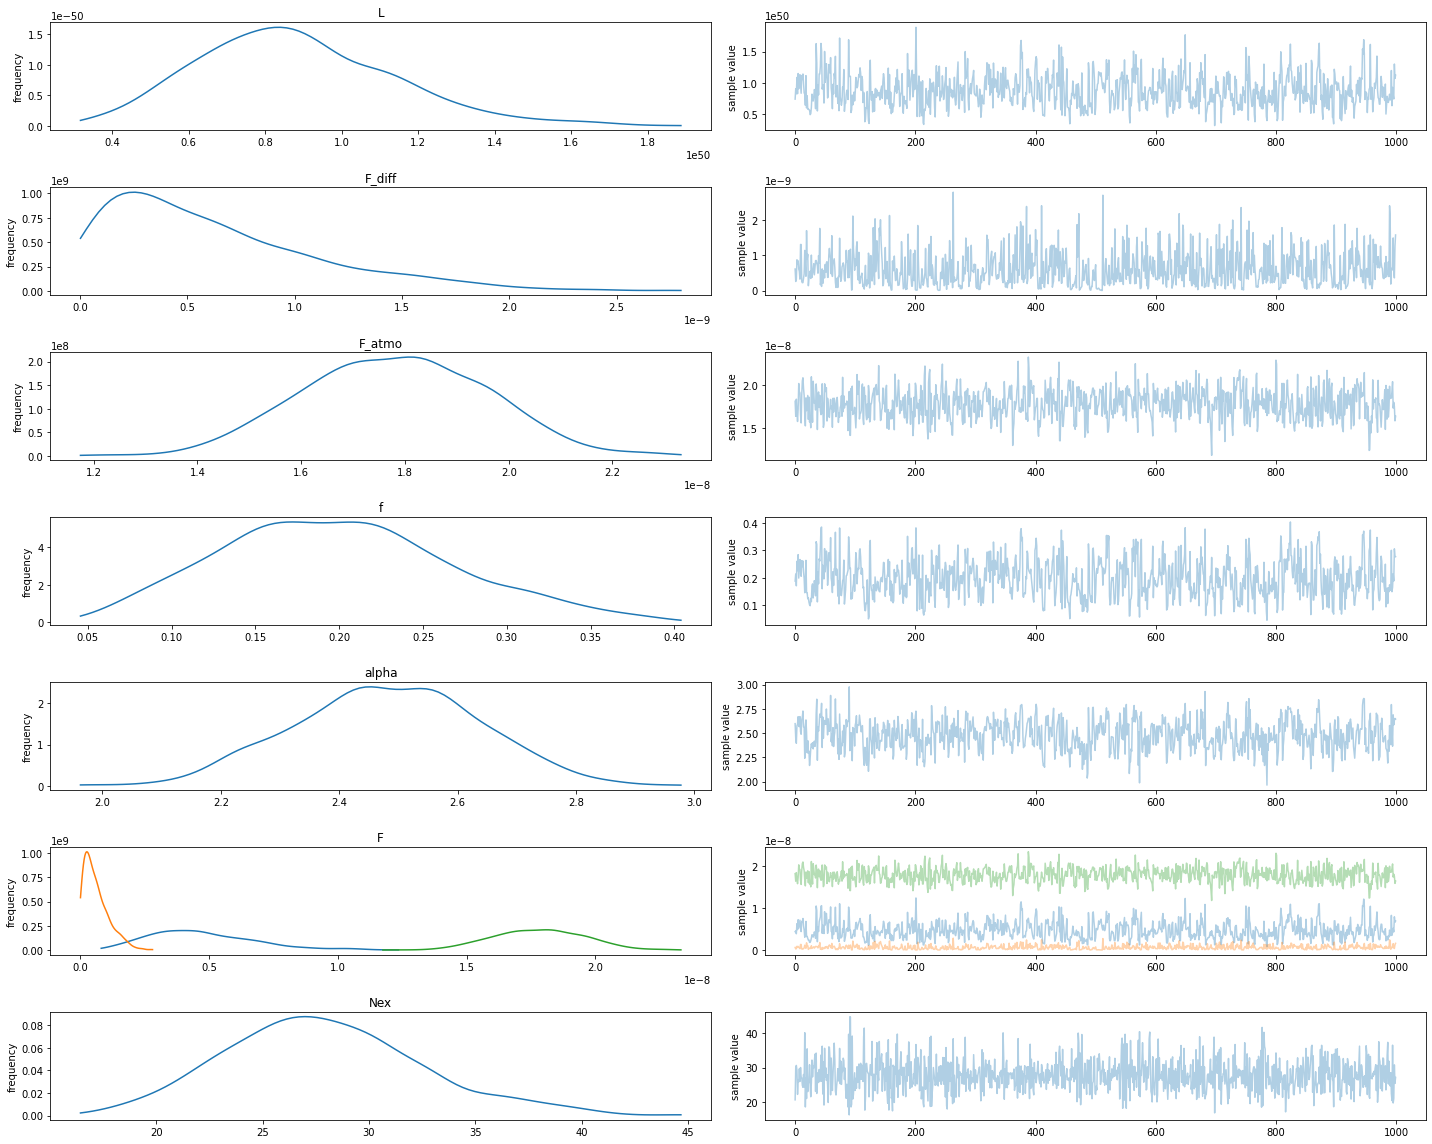

In [38]:
# View chains
fig = fit.plot([r'L', r'F_diff', r'F_atmo', r'f', r'alpha', r'F', r"Nex"]);
fig.set_size_inches(20, 16)
fig.tight_layout()

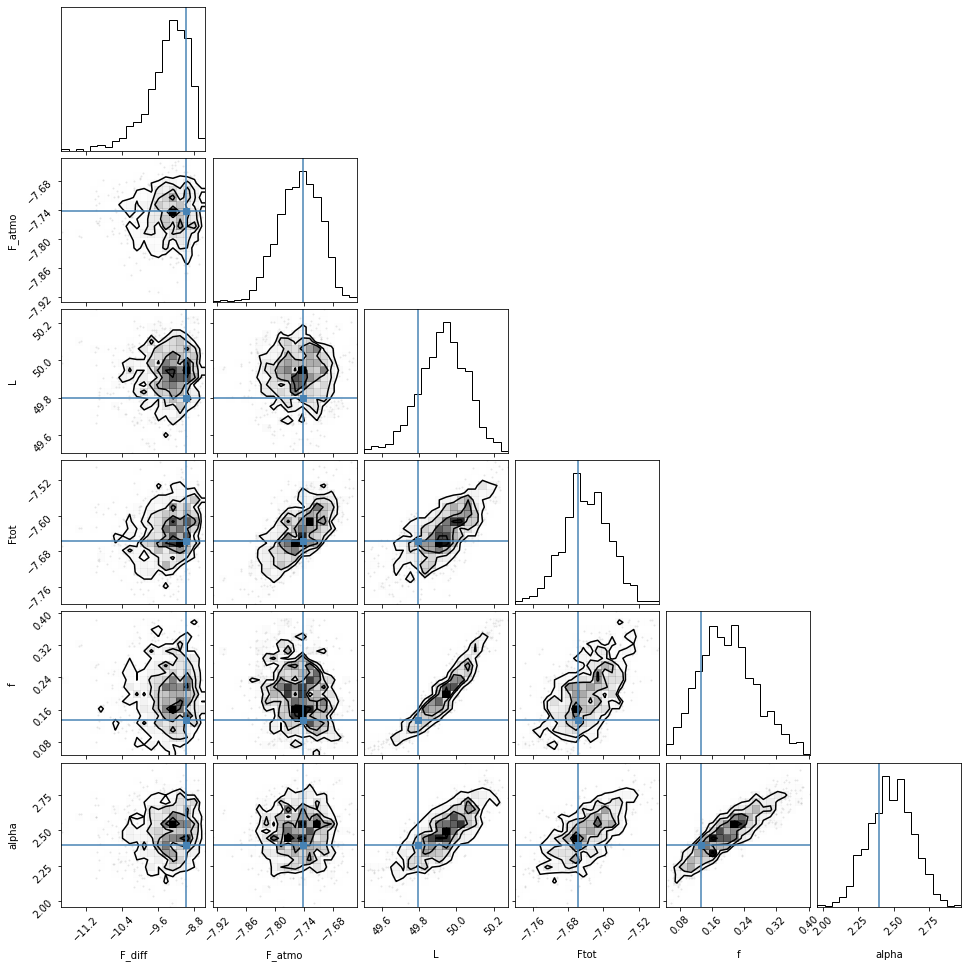

In [39]:
# View corner plot
chain = fit.extract(permuted = True)
key_list = ['F_diff', 'F_atmo', 'L', 'Ftot', 'f', 'alpha']
labels = [r'F_diff', 'F_atmo', r'L', r'Ftot', r'f', 'alpha']
truths = [np.log10(sim_inputs['F_diff']), np.log10(sim_inputs['F_atmo']), 
          np.log10(sim_inputs['L']), np.log10((sum(source_ints)).value), 
          (sum(source_ints[:-2]) / sum(source_ints)).value, 
          sim_inputs['alpha']]

corner.corner(np.column_stack([np.log10(chain['F_diff']), np.log10(chain['F_atmo']), 
                               np.log10(chain['L']), np.log10(chain['Ftot']), 
                               chain['f'], chain['alpha']]),
              labels = labels, truths = truths);

In [40]:
#chain = fit.extract(permuted = True)
logprob = chain['lp'].transpose(1, 2, 0)
N = np.shape(logprob)[0]

# Account for background components
Ns = np.shape(logprob)[1] - 2
labels = ["src", "diff", "atmo"]

In [41]:
# Calculate association probabilities for each source-neutrino combo
nu_p = []
for lp in logprob:
    lps = []
    for src in range(Ns+2):
        lps.append(np.mean(np.exp(lp[src])))

    norm = sum(lps)
    ps = []
    for src in range(Ns+2):
        ps.append(lps[src] / norm)
    nu_p.append(ps)

# Normalise line weights
pmax = max(max(nu_p))

In [42]:
# Check individual event classifications
counter = 0
wrong = []
for i in range(len(nu_p)):
    classified = np.where(nu_p[i] == np.max(nu_p[i]))[0][0] == int(lam[i])
    if not classified:
        counter += 1
        wrong.append(i)
        print("P(src) =", nu_p[i][0])
        print("P(diff) =", nu_p[i][1])
        print("P(atmo) =", nu_p[i][2])
        print("Actual component is", labels[int(lam[i])])
print("")
print(counter, "events out of", len(nu_p), "misclassified")


0 events out of 27 misclassified
